###Imports and parameters

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Colab Notebooks/nlp/data/'
data_path = working_dir+'sim_dataset_23082019.csv'
lm_data_path = working_dir+'he_htb-ud-train.txt'
eng_wiki_normal_path = working_dir+'normal.aligned'
eng_wiki_simple_path = working_dir+'simple.aligned'
results_dir = working_dir+'Results/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import numpy
from torch import autograd, nn, optim
import torch.nn.functional as F
import re
import random
import time
import math
import pandas
from sklearn.model_selection import train_test_split
import datetime
#import matplotlib # must be called here for plotting in nova
#matplotlib.use('pdf') # must be called here for plotting in nova
import matplotlib.pyplot as plt
import pickle
import json
from nltk.translate import bleu_score
from nltk.corpus import cmudict

#### Parameters definitions

In [0]:
hidden_size = 500
embedding_size = 200
n_layers = 2
dropout_p = 0.05
teacher_forcing_ratio = 1
n_epochs = 32
learning_rate = 0.0003

print_every = 1
print_loss_total = 0 # Reset every print_every
train_losses = []
val_losses = []
fk_belu_train = []
fk_belu_val = []
dic_reg_to_sim = {}
 

train_LM = False
train_LM_n_epochs = 30
train_LM_teacher_forcing_ratio = 0.7

train_LM_data_size = 6000#00 # 6000 is everything
data_size = 6000 # 121987 is everything in eng wiki
entires_1_2 = True # use only entires type 1 and 2
load_from_pickle = False
eng_wiki = False
load_model_flag = False
model_params_file = working_dir+"model_params_n_epochs_"+str(n_epochs)+".tar"
if eng_wiki:
  json_dir = working_dir+'SPPDB_lexicon.json'
else:
  json_dir = working_dir+'lexicon.json'


time = '{date:%Y-%m-%d_%H:%M:%S}'.format( date=datetime.datetime.now() ) 
if train_LM:
  files_suffix = '_epoch_%d_LM_epoch_%d_time_%s' %(n_epochs,train_LM_n_epochs,time)
elif eng_wiki:
  files_suffix = '_English_wiki_epoch_%d_time_%s' % (n_epochs,time)
else:
  files_suffix = '_epoch_%d_time_%s' % (n_epochs,time)

###Preprocessing

#### Vocabulary

In [0]:
SOS_TOKEN = 0
EOS_TOKEN = 1
UNKNOWN = 2
MAX_LENGTH = 30

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {UNKNOWN:'__unk__'}
        self.n_words = 3
    
    def index_sentence(self, sentence, write=True):
        indexes = []
        for w in sentence.strip().split(' '):
            indexes.append(self.index_word(w, write))
        return indexes
            
    def index_word(self, word, write=True):        
        if word not in self.word2index:
          if write:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words = self.n_words + 1
          else:
            return UNKNOWN
        return self.word2index[word]

#### Read and organize sentances

In [0]:
def normalize_string(s,only_heb=False):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    if only_heb:
      s = re.sub(r"[\u0590-\u05CF]+", "", s)
      s = re.sub(r"[^א-ת.!?]+", r" ", s)
      s = re.sub(r"(^|\s)\"(\w)", r"\1\2", re.sub(r"(\w)\"(\s|$)", r"\1\2", s))
    else:
      s = re.sub(r"[^a-zA-Zא-ת.!?]+", r" ", s)
    return s.strip()
  
def filter_pair(p):
    not_too_long = len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH
    not_too_short = len(p[0].split(' ')) > 1 and len(p[1].split(' ')) > 1
    return not_too_long and not_too_short

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [0]:
def read_langs(lang1, lang2):    
    if 'normal_heb' == lang1 or 'simple_heb' == lang2:
      df = pandas.read_csv(data_path, error_bad_lines=False)#, encoding='utf-8')
      if entires_1_2:
        df = df.loc[df['entry_type']<3]
      all_reg_sent = df['reg_sent']
      all_sim_sent = df['sim_sent']

      pairs = []
      for i in list(df.index.values):
        pairs.append([normalize_string(all_reg_sent[i],only_heb=True),normalize_string(all_sim_sent[i],only_heb=True)])
        
    if 'small_simple-wiki'==lang1 and 'small_normal-wiki'==lang2:
      # Read the file and split into lines
      lines = open('/content/drive/My Drive/Colab Notebooks/nlp/data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')

      # Split every line into pairs and normalize
      lines = [line.split('\t')[2] for line in lines]
      pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

      pairs = [pairs[i]+pairs[i+1] for i in range(0,len(lines),2)]
      
    if 'normal-wiki'==lang1 and 'simple-wiki'==lang2:
      # Read the files and split into lines
      normal_lines = open(eng_wiki_normal_path).read().strip().split('\n')
      simple_lines = open(eng_wiki_simple_path).read().strip().split('\n')
      
      # Split every line into pairs and normalize
      normal_lines = [line.split('\t')[2] for line in normal_lines]
      simple_lines = [line.split('\t')[2] for line in simple_lines]
      
      normal_lines = [[normalize_string(s) for s in l.split('\t')] for l in normal_lines]
      simple_lines = [[normalize_string(s) for s in l.split('\t')] for l in simple_lines]

      pairs = [normal_lines[i]+simple_lines[i] for i in range(len(normal_lines))]   
      
    if 'lm_train_heb'==lang1 and 'lm_train_heb'==lang2:
      lines = open(lm_data_path).read().strip().replace('\n', ' ').split('. ')
      pairs = [[normalize_string(line,only_heb=True),normalize_string(line,only_heb=True)] for line in lines]
        
    return pairs


def print_pair(p):
    print(p[0])
    print(p[1])

In [0]:
def pairs_to_data(pairs, size):
  X = []
  y = []

  for pair in pairs[:size]:
    if pair[0]!=' ' and pair[1]!= ' ': # delete empty pairs
      input_vocab.index_sentence(pair[0])
      output_vocab.index_sentence(pair[1])
      X.append(pair[0])
      y.append(pair[1])
  
  print("Trimmed to %s non-empty sentence pairs" % len(X))

  # Print example
  i = random.randint(0,len(X)-1)
  print(X[i])
  print(y[i])
  return numpy.asarray(X), numpy.asarray(y)
  

#### Init data

In [0]:
def init_data(input_vocab,output_vocab,dic_reg_to_sim):
  #input_vocab, output_vocab, pairs = prepare_data('simple-wiki', 'normal-wiki', True)
  
  print("Readin lexicon...")
  with open(json_dir,'r') as f: #,encoding='utf-8'
	   dic_reg_to_sim = json.load(f)
  
  print("Reading lines...")
  if train_LM:
    #pairs = prepare_data('lm_train_heb', 'lm_train_heb')
    pairs = read_langs('lm_train_heb', 'lm_train_heb')
    print("Read %s sentence pairs for LM" % len(pairs))    
    pairs = filter_pairs(pairs)
    X_lm, y_lm = pairs_to_data(pairs, train_LM_data_size)

  if eng_wiki:
    print("Data is in English from wikipedia")
    pairs = read_langs('normal-wiki', 'simple-wiki')
  else:
    print("Data is in Hebrew from our dataset")
    pairs = read_langs('normal_heb', 'simple_heb')
  print("Read %s sentence pairs" % len(pairs))    
  pairs = filter_pairs(pairs)
  X, y = pairs_to_data(pairs, data_size)
  #dic_reg_to_sim = build_dic_reg_to_sim()
  print("Sentences pairs left:%s" % len(X))

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

  del X,y,pairs
  
  print("Train size:",len(X_train))
  print("Validation size:",len(X_val))
  print("Test size:",len(X_test))

  print("Data is ready!")
  if train_LM:
    return input_vocab, output_vocab, dic_reg_to_sim, X_train, y_train, X_val, y_val, X_test, y_test, X_lm, y_lm
  else:
    return input_vocab, output_vocab, dic_reg_to_sim, X_train, y_train, X_val, y_val, X_test, y_test

###Models

####Encoder

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.bi_grus = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=False, bidirectional=True)

    def forward(self, word_inputs, hidden):
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
             
        output, hidden = self.bi_grus(embedded, hidden)

        return output, hidden

    def init_hidden(self):
        hidden = torch.zeros(self.n_layers*2, 1, self.hidden_size).cuda()
        return hidden

####Decoder with Attention

In [0]:
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        
        self.hidden_size = hidden_size 
        self.attn = nn.Linear(self.hidden_size, hidden_size)

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)
        attn_energies = torch.zeros(seq_len).cuda() # B x 1 x S
        
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies, 0).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):        
        energy = self.attn(encoder_output)        
        energy = hidden.view(-1).dot(energy.view(-1))
        return energy

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size * 2      
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(input_size=embedding_size+self.hidden_size, hidden_size=self.hidden_size, num_layers=n_layers, batch_first=False)
        self.out = nn.Linear(self.hidden_size * 2, output_size)
        self.attn = Attn(self.hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        
        #rnn_output, hidden = self.lstm(rnn_input, last_hidden)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)), 1)
        
        # Return final output, hidden state
        return output, context, hidden
      
    def init_hidden(self):
      hidden = torch.zeros(self.n_layers, 1, int(self.hidden_size)).cuda()
      return hidden

####Complex words simplifier

In [0]:
# # TODO
# import random
# def get_simple_word(org_sent, target_sent=None):
#   if target_sent is None: # Test time
#     org_index = random.randint(0,len(org_sent.split(' '))-1)
#     return org_sent.split(' ')[org_index],org_index # simplified, index in org_sent
#   else: # Train time
#     org_index = random.randint(0,len(org_sent.split(' '))-1)
#     target_index = random.randint(0,len(target_sent.split(' '))-1)
#     return target_sent.split(' ')[target_index],org_index,target_index # simplified, index in org_sent, index in target_sent

In [0]:
def simplify(word, lexicon):
	"""
	Assumes that the word is in the lexicon.
	Uses random.choice() since, if there are multiple simplifications, we want to
	pick randomly for them. If the word was simplified in the same way in
	multiple entries, then the .choice() accounts for the number of time they
	occur.
	:param str word: word to simplify
	:param dict lexicon: dict to map word to simple version
	:return:
	"""
	sim = random.choice(lexicon[word])[1]
	if type(sim) == str:
		sim = [sim]
	return " ".join(sim)


def get_simple_word_dict(org_sent, target_sent, lexicon, multi_word=0):
	"""
	Deal with no word in sentence: Pick random shared word. If non exists, pick random.
	Deal with multiple words in sentence: Pick first or Pick random. 
																				Random can be weighted or not.
																				Default first (multi_word=0)
	If multiple simplification - Random by weight - do be dealt with simplify() function
	Need index in target sentence in Train. If simplification not in there, then pick random.
	:param org_sent:
	:param target_sent:
	:param lexicon:
	:param multi_word:
	:return:
	"""
	potential = []
	org_sent_split = org_sent.split(' ')[:-1]
	target_sent_split = target_sent.split(' ')[:-1]
	for i, word in enumerate(org_sent_split):
		if word in lexicon.keys():
			potential.append((i, word))
	if len(potential) > 1:  # Multiple Potential Words to Simplify
		if multi_word == 0:  # Heuristic - Pick first word in sentence to simplify
			simplified = simplify(potential[0][1], lexicon)  # returns a string (can be multiple words)
			reg_index = potential[0][0]
		else:
			# Option 1 - Random choice with ints
			# rand_ind = random.randint(0, len(potential) - 1)
			# simplified = simplify(potential[rand_ind][1], lexicon)  # returns a string (can be multiple words)
			# reg_index = potential[rand_ind][0]
			# Option 2 - Random choice with choice
			# choice = random.choice(potential)
			# simplified = simplify(choice[1], lexicon)
			# reg_index = choice[0]
			# Option 3 - Random choice with choices (weighted
			ws = [len(lexicon[w[1]]) for w in potential]
			choice = random.choices(potential, ws)
			simplified = simplify(choice[0][1], lexicon)
			reg_index = choice[0][0]
	elif len(potential) == 1:  # One potential word to simplify
		simplified = simplify(potential[0][1], lexicon)  # returns a string (can be multiple words)
		reg_index = potential[0][0]
	else:  # No potential words found
		target_words = set(target_sent_split) if target_sent is not None else set()
		shared_words = (set(org_sent_split) & target_words) - set('.')
		simplified = random.choice(list(shared_words)) if shared_words != set() else random.choice(list(set(org_sent_split) - set('.')))
		reg_index = org_sent_split.index(simplified)
	if target_sent is not None:  # Training time:
		if simplified in target_sent:  # If simplified in sim_sentence, then find index
			sim_index = target_sent_split.index(simplified.split(' ')[0])  # index of first word of simplified
		else:  # else pick random index
			sim_index = random.randint(0, len(target_sent_split) - 1)
		return simplified, reg_index, sim_index  # simplified, index in org_sent, index in target_sent
	else:  # Test time:
		return simplified, reg_index  # simplified, index in org_sent


def get_simple_word_rand(org_sent, target_sent=None):
	if target_sent is None:  # Test time
		org_index = random.randint(0, len(org_sent.split(' '))-1)
		return org_sent.split(' ')[org_index], org_index  # simplified, index in org_sent
	else:  # Train time
		org_index = random.randint(0, len(org_sent.split(' '))-1)
		target_index = random.randint(0, len(target_sent.split(' '))-1)
		return target_sent.split(' ')[target_index], org_index, target_index  # simplified, index in org_sent, index in target_sent


def get_simple_word(org_sent, target_sent=None, get_kind=0, lex=dic_reg_to_sim):
	assert type(get_kind) == int and get_kind < 4
	if get_kind == 0:
		return get_simple_word_rand(org_sent, target_sent)
	elif get_kind == 1:
		return get_simple_word_dict(org_sent, target_sent, lexicon=lex)
	elif get_kind == 2:
		pass
		# return get_simple_word_classifier(org_sent, target_sent=None, lexicon=lex)

#### Save and Load models

In [0]:
def save_model(epoch):
  torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'forward_decoder_state_dict': forward_decoder.state_dict(),
            'backward_decoder_state_dict': backward_decoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'forward_decoder_optimizer_state_dict': forward_decoder_optimizer.state_dict(),
            'backward_decoder_optimizer_state_dict': backward_decoder_optimizer.state_dict(),     
            'train_losses': train_losses,
            'val_losses': val_losses,
            'fk_belu_train': fk_belu_train,
            'fk_belu_val': fk_belu_val,
            'files_suffix': files_suffix,
            }, working_dir+"model_params_n_epochs_"+str(n_epochs)+".tar")
  print("Saved file:'"+model_params_file+" for epoch:",str(epoch))


def load_model():
  device = torch.device("cuda")
#   encoder = EncoderRNN(input_vocab.n_words, embedding_size, hidden_size, n_layers).cuda()
#   forward_decoder = AttnDecoderRNN(hidden_size, embedding_size, output_vocab.n_words, n_layers, dropout_p=dropout_p).cuda()
#   backward_decoder = AttnDecoderRNN(hidden_size, embedding_size, output_vocab.n_words, n_layers, dropout_p=dropout_p).cuda()
#   encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
#   forward_decoder_optimizer = optim.Adam(forward_decoder.parameters(), lr=learning_rate)
#   backward_decoder_optimizer = optim.Adam(backward_decoder.parameters(), lr=learning_rate)

  checkpoint = torch.load(working_dir+"model_params_n_epochs_"+str(n_epochs)+".tar")
  
  encoder.load_state_dict(checkpoint['encoder_state_dict'])
  forward_decoder.load_state_dict(checkpoint['forward_decoder_state_dict'])
  backward_decoder.load_state_dict(checkpoint['backward_decoder_state_dict'])
  
  encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
  forward_decoder_optimizer.load_state_dict(checkpoint['forward_decoder_optimizer_state_dict'])
  backward_decoder_optimizer.load_state_dict(checkpoint['backward_decoder_optimizer_state_dict'])
  
  epoch = checkpoint['epoch']
  train_losses = checkpoint['train_losses']
  val_losses = checkpoint['val_losses']
  fk_belu_train = checkpoint['fk_belu_train']
  fk_belu_val = checkpoint['fk_belu_val']
  files_suffix = checkpoint['files_suffix']
  
  encoder.to(device)
  forward_decoder.to(device)
  backward_decoder.to(device)
  encoder.train()
  forward_decoder.train()
  backward_decoder.train()
  
  return encoder,forward_decoder,backward_decoder,encoder_optimizer,forward_decoder_optimizer,backward_decoder_optimizer,epoch, train_losses, val_losses, fk_belu_train, fk_belu_val, files_suffix

### Train and Evaluation functions

####Train function

In [0]:
def train(input_tensor, backward_target_tensor, forward_target_tensor, simplified_word, forward_decoder, backward_decoder,
          encoder_optimizer, forward_decoder_optimizer, backward_decoder_optimizer, criterion, teacher_forcing_ratio=1, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    backward_decoder_optimizer.zero_grad()
    forward_decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word
    
    # Get size of input and target sentences
    input_length = input_tensor.size()[0]
    backward_target_length = backward_target_tensor.size()[0]
    forward_target_length = forward_target_tensor.size()[0]
    
    loss += run_model(input_tensor, backward_target_tensor, forward_target_tensor, input_length, backward_target_length, forward_target_length,
                      simplified_word, backward_decoder, forward_decoder, criterion)

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    backward_decoder_optimizer.step()
    forward_decoder_optimizer.step()
    
    return loss.item() / (backward_target_length+forward_target_length)

In [0]:
def run_model(input_tensor, backward_target_tensor, forward_target_tensor, input_length, backward_target_length, forward_target_length, simplified_word, backward_decoder,
              forward_decoder, loss_func, teacher_forcing_ratio=teacher_forcing_ratio): 
  loss = 0 # Added onto for each word

  # Run words through encoder
  encoder_hidden = encoder.init_hidden()
  
  encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
  
  # Prepare input and output variables
  forward_decoder_input = torch.LongTensor([[output_vocab.index_word(simplified_word, write=False)]]).cuda() #forward pass from y_s
  forward_decoder_context = torch.zeros(1, forward_decoder.hidden_size).cuda()
  backward_decoder_input = torch.LongTensor([[output_vocab.index_word(simplified_word, write=False)]]).cuda()
  backward_decoder_context = torch.zeros(1, forward_decoder.hidden_size).cuda()

  backward_decoder_hidden = encoder_hidden.view(-1,1,encoder_hidden.shape[2]*2) # Use last hidden state from encoder to start decoder
  # change here#forward_decoder_hidden = encoder_hidden.view(-1,1,encoder_hidden.shape[2]*2) # Use last hidden state from encoder to start decoder 

  # Run model on input

  # Choose whether to use teacher forcing (Teacher forcing: Use the ground-truth target as the next input)
  use_teacher_forcing = random.random() < teacher_forcing_ratio
  if use_teacher_forcing: 
      # Backward pass
      for di in range(backward_target_length):
          backward_decoder_output, backward_decoder_context, backward_decoder_hidden = backward_decoder(
              backward_decoder_input, backward_decoder_context, backward_decoder_hidden, encoder_outputs)
          loss += loss_func(backward_decoder_output[0].view(-1).unsqueeze(0), backward_target_tensor[di].unsqueeze(0))
          backward_decoder_input = backward_target_tensor[di] # Next target is next input

      # Forward pass
      forward_decoder_hidden = backward_decoder_hidden # change here
      for di in range(forward_target_length):
          forward_decoder_output, forward_decoder_context, forward_decoder_hidden = forward_decoder(
              forward_decoder_input, forward_decoder_context, forward_decoder_hidden, encoder_outputs)
          loss += loss_func(forward_decoder_output[0].view(-1).unsqueeze(0), forward_target_tensor[di].unsqueeze(0))
          forward_decoder_input = forward_target_tensor[di] # Next target is next input

  else: # Without teacher forcing: use network's own prediction as the next input
      # Backward pass
      for di in range(backward_target_length):
          backward_decoder_output, backward_decoder_context, backward_decoder_hidden = backward_decoder(
              backward_decoder_input, backward_decoder_context, backward_decoder_hidden, encoder_outputs)
          loss += loss_func(backward_decoder_output[0].view(-1).unsqueeze(0), backward_target_tensor[di].unsqueeze(0))

          # Get most likely word index (highest value) from output
          topv, topi = backward_decoder_output.topk(1)
          ni = topi[0][0]

          backward_decoder_input = torch.LongTensor([[ni]]).cuda() # Chosen word is next input

          # Stop at start of sentence (not necessary when using known targets)
          if ni == SOS_TOKEN: break

      # Forward pass
      forward_decoder_hidden = backward_decoder_hidden # change here
      for di in range(forward_target_length):
          forward_decoder_output, forward_decoder_context, forward_decoder_hidden = forward_decoder(
              forward_decoder_input, forward_decoder_context, forward_decoder_hidden, encoder_outputs)
          loss += loss_func(forward_decoder_output[0].view(-1).unsqueeze(0), forward_target_tensor[di].unsqueeze(0))

          # Get most likely word index (highest value) from output
          topv, topi = forward_decoder_output.topk(1)
          ni = topi[0][0]

          forward_decoder_input = torch.LongTensor([[ni]]).cuda() # Chosen word is next input

          # Stop at end of sentence (not necessary when using known targets)
          if ni == EOS_TOKEN: break
    
  return loss

#### Evaluation functions

In [0]:
def evaluate_val_loss(backward_decoder, forward_decoder,teacher_forcing_ratio=0):
    backward_decoder.eval()
    forward_decoder.eval()
    encoder.eval()
    #cur_val_loss = 0
    val_loss_sum = 0
    fk_belu = 0
    
    for i in range(len(X_val)):    
      pair = (X_val[i],y_val[i])         
      # Finding the complex word x_c and setting simple word y_s    
      simplified_word, org_index , target_index = get_simple_word(pair[0],pair[1]) 
      input_tensor = torch.tensor([SOS_TOKEN]+(input_vocab.index_sentence(pair[0], write=False))+[EOS_TOKEN]).cuda()
      backward_target_tensor = torch.tensor((output_vocab.index_sentence(pair[1], write=False)[target_index-1::-1])+[SOS_TOKEN]).cuda() # from y_s-1 to SOS
      forward_target_tensor = torch.tensor((output_vocab.index_sentence(pair[1], write=False)[target_index+1:])+[EOS_TOKEN]).cuda() # from y_s+1 to EOS
      
      # Get size of input and target sentences
      input_length = input_tensor.size()[0]
      backward_target_length = backward_target_tensor.size()[0]
      forward_target_length = forward_target_tensor.size()[0]
      
      cur_val_loss = run_model(input_tensor, backward_target_tensor, forward_target_tensor, input_length, backward_target_length, forward_target_length,
                               simplified_word, backward_decoder, forward_decoder, nn.NLLLoss())
      val_loss_sum += cur_val_loss.item() / (backward_target_length+forward_target_length)
      
      fk_belu += FKBLEU([pair[0].split(' ')], [pair[1].split(' ')], evaluate(pair[0])[1:-1])
    
    backward_decoder.train()
    forward_decoder.train()
    encoder.train()
    
    return val_loss_sum/len(X_val), fk_belu/len(X_val)
  

In [0]:
def run_decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs, max_length=MAX_LENGTH, is_backward=None):
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length).cuda()
    
    # Run through decoder
    for di in range(max_length):
        if is_backward:
          decoder_output, decoder_context, decoder_hidden = backward_decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        else:
          decoder_output, decoder_context, decoder_hidden = forward_decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        # Choose top word from output
        topv, topi = decoder_output.cpu().topk(1)
        ni = topi[0][0].item()        
        
        if (ni == SOS_TOKEN and is_backward) or (ni == EOS_TOKEN and not is_backward):
            if is_backward:
              decoded_words.append('<SOS>')
            else:
              decoded_words.append('<EOS>')
            break
        else:
            if ni == SOS_TOKEN:
               decoded_words.append("<SOS?>")
            elif ni == EOS_TOKEN:
               decoded_words.append("<EOS?>")
            else:
               decoded_words.append(output_vocab.index2word[ni])
            
        # Next input is chosen word
        decoder_input = torch.LongTensor([[ni]]).cuda()
        
    return decoded_words, decoder_hidden
  

In [0]:
def evaluate(sentence, max_length=MAX_LENGTH):
      
    input_tensor = torch.tensor(input_vocab.index_sentence(sentence)).cuda()
    input_length = input_tensor.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    # Finding the complex word x_c and setting simple word y_s    
    simplified_word, org_index = get_simple_word(sentence) 

    # Create starting vectors for backward decoder
    backward_decoder_input = torch.LongTensor([[output_vocab.index_word(simplified_word, write=False)]]).cuda() # y_s
    backward_decoder_context = torch.zeros(1, backward_decoder.hidden_size).cuda()
    backward_decoder_hidden = encoder_hidden.view(-1,1,encoder_hidden.shape[2]*2) # Use last hidden state from encoder to start decoder
    
    # Create starting vectors for forward decoder
    forward_decoder_input = torch.LongTensor([[output_vocab.index_word(simplified_word, write=False)]]).cuda() # SOS
    forward_decoder_context = torch.zeros(1, forward_decoder.hidden_size).cuda()
    #forward_decoder_hidden = encoder_hidden.view(-1,1,encoder_hidden.shape[2]*2) # Use last hidden state from encoder to start decoder
    
    # Run through decoders
    backward_words, backward_decoder_hidden = run_decoder(backward_decoder_input, backward_decoder_context, backward_decoder_hidden, encoder_outputs, max_length, is_backward=True)
    forward_words, _ = run_decoder(forward_decoder_input, forward_decoder_context, backward_decoder_hidden, encoder_outputs, max_length, is_backward=False)
    
    # Bulid sentance
    simplified_word = simplified_word 
    decoded_words = backward_words[::-1]+[simplified_word]+forward_words
    
    return decoded_words # with no SOS and EOS

In [0]:
def evaluate_randomly():
    #pair = random.choice(pairs)
    i = random.randint(0,len(X_val)-1)
    pair = [X_val[i],y_val[i]]
  
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print("Validation example")
    print('FKBLEU: ', FKBLEU([pair[0].split(' ')], [pair[1].split(' ')], output_words[1:-1]))
    print(pair[0])
    print(pair[1])
    print(output_sentence)
    
def evaluate_idx(idx):
    #pair = random.choice(pairs)
    for i in idx:
      pair = [X_val[i],y_val[i]]

      output_words = evaluate(pair[0])
      output_sentence = ' '.join(output_words)

      print("Validation example")
      print('FKBLEU: ', FKBLEU([pair[0].split(' ')], [pair[1].split(' ')], output_words[1:-1]))
      print(pair[0])
      print(pair[1])
      print(output_sentence[1:-1])
      print('\n')
    
    
def evaluate_randomly_train():
    #pair = random.choice(pairs)
    i = random.randint(0,len(X_train)-1)
    pair = [X_train[i],y_train[i]]
  
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print("Train example")
    print('FKBLEU: ', FKBLEU([pair[0].split(' ')], [pair[1].split(' ')], output_words[1:-1]))
    print(pair[0])
    print(pair[1])
    print(output_sentence)
    

##### FKBELU

In [0]:
def iBLEU(input_sent, reference, candidate, alpha=0.9):
	"""
	Calculate iBLEU according to Xu et. al. 2016
	:param input_sent: original sentence
	:param reference: the target sentences to test by
	:param candidate: a proposed sentence from the input
	:param alpha: default param 0.9 from Sun and Zhou (2012)
	:return:
	"""
	smooth = bleu_score.SmoothingFunction()
	if len(candidate) < 2:
		return 0.0
	ref_candidate = bleu_score.sentence_bleu(reference, candidate, smoothing_function=smooth.method7)
	input_candidate = bleu_score.sentence_bleu(input_sent, candidate, smoothing_function=smooth.method7)
	# print('ref_candidate:', '%s; ' % ref_candidate, 'input_candidate:','%s; ' % input_candidate)
	# print('iBLEU (alpha * ref_candidate - (1 - alpha) * input_candidate) =\n %s' % (alpha * ref_candidate - (1 - alpha) * input_candidate))
	return alpha * ref_candidate - (1 - alpha) * input_candidate

	

def FK(text, language='heb'):
	"""
	TODO: count syllables not with heuristic
	Calculate Flesch-Kincaid Index (Kincaid et al 1975) according to Xu et. al. 2016
	:param language: Used for syllables count heuristic
	:param text: Assumes is a list of lists of words (list of sentences as lists of words)
	:return:
	"""
	# if isinstance(text, list) and all(isinstance(sen, list) for sen in text):
	# 	for sen in text:
	# 		assert all(isinstance(w, str) for w in sen)
	
	num_words = 0
	num_sents = 0
	num_syllables = 0
	if eng_wiki:#language == 'eng':
		#parser = pyphen.Pyphen('en_us')
		try:
			parser = cmudict.dict()
		except LookupError:
			import nltk
			nltk.download('cmudict')
			parser = cmudict.dict()
	else:
		parser = None
	# Gather numerical calculations
	for sen in text:
		num_sents += 1
		for word in sen:
			num_words += 1
			if language == 'heb':  # heuristic that each letter is a syllable in hebrew
				num_syllables += len(word)
			elif language == 'eng':  # syllable parser for English
				num_syllables += len(parser.inserted(word).split('-'))
	# print('Words, Sents, Syllables: %s, %s, %s' % (num_words, num_sents, num_syllables))
	return 0.39 * (num_words / num_sents) + 11.8 * (num_syllables / num_words) - 15.59


def FKdiff(input_sent, candidate):
  """
  
  :param input_sent: Assumes input sent is a list of lists of words
  :param candidate: Assumes candidate is a list of words
  :return:
  """
  # using torch
  # print('FKdiff:', torch.sigmoid(FK([candidate]) - FK(input_sent)))
  # return torch.nn.functional.sigmoid(FK([candidate]) - FK(input_sent))
  # using python native
  x = FK([candidate]) - FK(input_sent)
  # print('FK(candidate): %s;  FK(input_sent): %s' % (FK([candidate]), FK(input_sent)))
  # print('x: %s' % x)
  # print('FKdiff:', 1 / (1 + numpy.exp(-x)))
  return 1 / (1 + numpy.exp(-x))


def FKBLEU(input_sent, references, candidate):
	"""
	Calculate iBLEU according to Xu et. al. 2016
	:param input_sent: original sentence. Assumes list of lists of words
	:param references: the target sentences to test by. Assumes list of lists of words
	:param candidate: a proposed sentence from the input. List of words.
	:return: (FK_BELU)
	"""
	#print('Input: %s, refrences: %s, candidate: %s' % (input_sent, references, candidate))
	i_belu = iBLEU(input_sent, references, candidate)
	fk_diff = FKdiff(input_sent, candidate)
	return i_belu * fk_diff#, i_belu, FK([candidate])

#### Create results files

In [0]:
# Write results to file
def evaluate_validation():
  fk_belu = 0
  i_belu = 0
  fk = 0
  f = open(results_dir+'Results'+files_suffix+'.txt', 'w+')
  
  for i in range(len(X_val)):
    pair = [X_val[i],y_val[i]]
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    f.write("This is line %d\r\n" % (i+1))
    f.write(pair[0]+" \n")
    f.write(pair[1]+" \n")
    f.write(output_sentence+" \n")
    input_sent = [pair[0].split(' ')]
    references = [pair[1].split(' ')]
    candidate = output_words[1:-1]
    fk_belu += FKBLEU(input_sent, references , candidate)
    i_belu += iBLEU(input_sent, references, candidate)
    fk += FK(candidate)
  print("###########################################")
  print("\n This is FK-BELU on the validation %.18f \n" % (fk_belu/len(X_val)))
  print("\n This is iBELU on the validation %.18f \n" % (i_belu/len(X_val)))
  print("\n This is FK on the validation %.18f \n" % (fk/len(X_val)))
  f.write("\n This is FK-BELU on the validation %.18f \n" % (fk_belu/len(X_val)))
  f.write("\n This is i_belu on the validation %.18f \n" % (i_belu/len(X_val)))
  f.write("\n This is FK on the validation %.18f \n" % (fk/len(X_val)))
  f.write("\n Those are the run parameters: LR %.5f, dropout %.5f, n_layers %d, embedding_size %d,hidden_size %d \n" % (learning_rate,dropout_p,n_layers,embedding_size,hidden_size))
  print("Wrote those results to file")
  f.close()

In [0]:
class Plotter:
    def __init__(self, first_losses, fist_label, sec_losses, sec_label, title='Negative Log Likelihood Loss'):
        self.first_losses = first_losses
        self.fist_label = fist_label
        self.sec_losses = sec_losses
        self.sec_label = sec_label
        self.title = title

    def plot(self, file_name):
        """Plot the loss per epoch"""
        line1, = plt.plot(range(len(self.first_losses)), self.first_losses, label=self.fist_label)
        line2, = plt.plot(range(len(self.sec_losses)), self.sec_losses, label=self.sec_label)
        plt.legend(handles=[line1,line2])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(self.title)
        plt.grid(True)
        plt.savefig(file_name)

###Running models

####Models' init

In [24]:
# Data Load

try:
  if not load_from_pickle:
    raise IOError("Do not load from pickle!")
  if train_LM:
    input_vocab, output_vocab, dic_reg_to_sim, X_train, y_train, X_val, y_val, X_test, y_test, X_lm, y_lm = pickle.load(open(working_dir+"learned_data.pickle", "rb"))
  else:
    input_vocab, output_vocab, dic_reg_to_sim, X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(open(working_dir+"learned_data.pickle", "rb"))
except (OSError, IOError) as e:
  input_vocab = Vocab("Heb-reg")
  output_vocab = Vocab("Heb-simple")
  dic_reg_to_sim = {}
  if train_LM:
    input_vocab, output_vocab, dic_reg_to_sim, X_train, y_train, X_val, y_val, X_test, y_test, X_lm, y_lm = init_data(input_vocab,output_vocab,dic_reg_to_sim)
    pickle.dump([input_vocab, output_vocab, dic_reg_to_sim, X_train, y_train, X_val, y_val, X_test, y_test, X_lm, y_lm], open(working_dir+"learned_data.pickle", "wb"))
  else:
    input_vocab, output_vocab, dic_reg_to_sim, X_train, y_train, X_val, y_val, X_test, y_test = init_data(input_vocab,output_vocab,dic_reg_to_sim)
    pickle.dump([input_vocab, output_vocab, dic_reg_to_sim, X_train, y_train, X_val, y_val, X_test, y_test], open(working_dir+"learned_data.pickle", "wb"))
  
# Initialize models
encoder = EncoderRNN(input_vocab.n_words, embedding_size, hidden_size, n_layers).cuda()
forward_decoder = AttnDecoderRNN(hidden_size, embedding_size, output_vocab.n_words, n_layers, dropout_p=dropout_p).cuda()
backward_decoder = AttnDecoderRNN(hidden_size, embedding_size, output_vocab.n_words, n_layers, dropout_p=dropout_p).cuda()

encoder.train()
forward_decoder.train()
backward_decoder.train()

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
forward_decoder_optimizer = optim.Adam(forward_decoder.parameters(), lr=learning_rate)
backward_decoder_optimizer = optim.Adam(backward_decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Readin lexicon...
Reading lines...
Data is in Hebrew from our dataset
Read 1406 sentence pairs
Trimmed to 1244 non-empty sentence pairs
כלבי נחייה
כלבי נחייה
Sentences pairs left:1244
Train size: 1062
Validation size: 119
Test size: 63
Data is ready!


####Training as LM

In [0]:
if train_LM:
  print("Training model as LM...")
  
  if load_model_flag:
    print("Loading model's parameters in LM...")
    encoder,forward_decoder,backward_decoder,encoder_optimizer,forward_decoder_optimizer,backward_decoder_optimizer,epoch, train_losses, val_losses, fk_belu_train, fk_belu_val, files_suffix = load_model()
    print("Training LM from epoch: ",epoch)
  else:
    epoch = 1
  
  f = open(results_dir+'Train_LM_loss_'+files_suffix+'.txt', 'w+')
  
  while epoch < train_LM_n_epochs + 1:
      for i in range(len(X_lm)):
        pair = (X_lm[i],y_lm[i])        
        splitting_index = (len(pair[0].split(' '))-1)//2
        simplified_word = output_vocab.index_word(pair[1].split(' ')[splitting_index])

        input_tensor = torch.tensor([SOS_TOKEN]+(input_vocab.index_sentence(pair[0], write=False))+[EOS_TOKEN]).cuda()
        backward_target_tensor = torch.tensor((output_vocab.index_sentence(pair[1], write=False)[splitting_index-1::-1])+[SOS_TOKEN]).cuda() # from y_s-1 to SOS
        forward_target_tensor = torch.tensor((output_vocab.index_sentence(pair[1], write=False)[splitting_index+1:])+[EOS_TOKEN]).cuda() # from y_s+1 to EOS

        # Run the train function
        loss = train(input_tensor, backward_target_tensor, forward_target_tensor, simplified_word, forward_decoder, backward_decoder,
                     encoder_optimizer, forward_decoder_optimizer, backward_decoder_optimizer, criterion,train_LM_teacher_forcing_ratio)

        # Keep track of loss
        print_loss_total += loss
        if i == 0: continue
          

        if i % 100 == 0:
            print_loss_avg = print_loss_total / i
            print('(Epoch %d)(pair number %d) %.4f' % (epoch,i, print_loss_avg))

      if epoch == 0: continue

      if epoch % print_every == 0:
          print_loss_avg = print_loss_total / (print_every * len(X_lm))
          print_loss_total = 0
          print('(Epoch %d) %.4f' % (epoch, print_loss_avg))
          f.write("(Epoch %d) %.4f \n" % (epoch, print_loss_avg))
      epoch += 1
      save_model(epoch)

  print("Done!")
  f.close()



In [26]:
print(output_vocab.n_words)
#import math
#print("First loss should be:",-math.log(1/output_vocab.n_words))

3384


#### Training

In [27]:
# Begin!

print("Training...")

if load_model_flag and not train_LM:
  print("Loading model's parameters...")
  encoder,forward_decoder,backward_decoder,encoder_optimizer,forward_decoder_optimizer,backward_decoder_optimizer,epoch, train_losses, val_losses, fk_belu_train, fk_belu_val, files_suffix = load_model()
  print("Training from epoch: ",epoch)
else:
  epoch = 1

f = open(results_dir+'Train_loss_'+files_suffix+'.txt', 'w+')
f_2 = open(results_dir+'Validation_loss_'+files_suffix+'.txt', 'w+')

while epoch < n_epochs + 1:
    
    # Get training data for this cycle
    for i in range(len(X_train)):
      pair = (X_train[i],y_train[i])
      
      # Finding the complex word x_c and setting simple word y_s    
      simplified_word, org_index , target_index = get_simple_word(pair[0],pair[1]) 

      input_tensor = torch.tensor([SOS_TOKEN]+(input_vocab.index_sentence(pair[0], write=False))+[EOS_TOKEN]).cuda() # with EOS in the end
      backward_target_tensor = torch.tensor((output_vocab.index_sentence(pair[1], write=False)[target_index-1::-1])+[SOS_TOKEN]).cuda() # from y_s-1 to SOS

      #forward_target_tensor = torch.tensor([SOS_TOKEN]+(output_vocab.index_sentence(pair[1], write=False))+[EOS_TOKEN]).cuda() # from SOS to EOS (use only y_s+1 to EOS)
      forward_target_tensor = torch.tensor((output_vocab.index_sentence(pair[1], write=False)[target_index+1:])+[EOS_TOKEN]).cuda() # from y_s+1 to EOS

      # Run the train function
      loss = train(input_tensor, backward_target_tensor, forward_target_tensor, simplified_word, forward_decoder, backward_decoder,
                   encoder_optimizer, forward_decoder_optimizer, backward_decoder_optimizer, criterion,teacher_forcing_ratio)
            
      
      # Keep track of loss
      print_loss_total += loss
      
      if i == 0: continue

      if i % 100 == 0:
          print_loss_avg = print_loss_total / i
          print('(Epoch %d)(pair number %d) %.4f' % (epoch,i, print_loss_avg))

    if epoch == 0: continue

    if epoch % print_every == 0:
        # Estimate FKBELU
        fk_belu = 0
        idx = random.sample(range(len(X_train)), min(1000,len(X_train))) # get 1000 random indexes
        for i in idx: 
          pair = (X_train[i],y_train[i])
          fk_belu += FKBLEU([pair[0].split(' ')], [pair[1].split(' ')], evaluate(pair[0])[1:-1])
        fk_belu /= min(1000,len(X_train))
        
        # Train loss
        print_loss_avg = print_loss_total / (print_every*len(X_train))
        print_loss_total = 0
        print('(Epoch %d) Train loss %.4f , fk_belu %.18f \n' % (epoch, print_loss_avg, fk_belu))
        f.write("(Epoch %d) Train loss %.4f , fk_belu %.18f \n" % (epoch, print_loss_avg, fk_belu))    
        train_losses.append(print_loss_avg) 
        fk_belu_train.append(fk_belu)
        
        # Validation loss
        val_loss, fk_belu = evaluate_val_loss(backward_decoder, forward_decoder,teacher_forcing_ratio=0)
        print('(Epoch %d) Validation loss %.4f , fk_belu %.18f \n' % (epoch, val_loss, fk_belu))
        f_2.write("(Epoch %d) %.4f , fk_belu %.18f \n" % (epoch, val_loss, fk_belu))
        val_losses.append(val_loss)
        fk_belu_val.append(fk_belu)
    epoch += 1
    save_model(epoch)

print("Done!")

f.close()
f_2.close()

Training...
(Epoch 1)(pair number 100) 6.5798
(Epoch 1)(pair number 200) 6.4007
(Epoch 1)(pair number 300) 6.3265
(Epoch 1)(pair number 400) 6.3122
(Epoch 1)(pair number 500) 6.3566
(Epoch 1)(pair number 600) 6.4513
(Epoch 1)(pair number 700) 6.4674
(Epoch 1)(pair number 800) 6.5201
(Epoch 1)(pair number 900) 6.5321
(Epoch 1)(pair number 1000) 6.5443
(Epoch 1) Train loss 6.5371 , fk_belu 0.037927681736526352 

(Epoch 1) Validation loss 6.3982 , fk_belu 0.038229808090721316 

Saved file:'/content/drive/My Drive/Colab Notebooks/nlp/data/model_params_n_epochs_32.tar for epoch: 2
(Epoch 2)(pair number 100) 6.0590
(Epoch 2)(pair number 200) 5.9946
(Epoch 2)(pair number 300) 5.9052
(Epoch 2)(pair number 400) 5.8751
(Epoch 2)(pair number 500) 5.8133
(Epoch 2)(pair number 600) 5.8364
(Epoch 2)(pair number 700) 5.8043
(Epoch 2)(pair number 800) 5.8038
(Epoch 2)(pair number 900) 5.7818
(Epoch 2)(pair number 1000) 5.7711
(Epoch 2) Train loss 5.7548 , fk_belu 0.034323921453290780 

(Epoch 2) Valid

#### Evaluate

In [28]:
for i in range(3):
    evaluate_randomly()
    print('\n')


Validation example
FKBLEU:  0.06007813382316891
לפני השיר שלך אני רוצה להראות לך משהו שהסתתרת מאיתנו היטב !
לפני שנראה קצת מהשיר שלך אני רוצה לדבר איתך . מה יש בתמונה הזאת ?
<SOS> אבל אנחנו צריכים אתכם פה איתנו שהסתתרת יותר . <EOS>


Validation example
FKBLEU:  0.24937625272823746
כן יהי רצון .
כן יהי רצון .
<SOS> את כל השירים הכי טובים יעלו לגמר . רצון כל כך שעלו לגמר . <EOS>


Validation example
FKBLEU:  -2.582373322277759e-07
הרצאה הסתכלות מערכתית על השילוב בגן הילדים מטי זכאי משיח אוניברסיטת תל אביב ומכללת בית ברל
חשיבה מערכתית כללית על השילוב בגן ילדים מטי זכאי משיח
<SOS> בשנת מדינת ישראל תל חי יונתן רוזמן שירלי קני <EOS>




In [29]:
for i in range(3):
    evaluate_randomly_train()
    print('\n')

Train example
FKBLEU:  0.14570360576324712
אתחיל עם זאת שפתחה את הלילה .
אני אתחיל לדבר עם הזמרת ששרה ראשונה היום בערב .
<SOS> היום אנחנו פוגשים את הזמרים שפתחה . <EOS>


Train example
FKBLEU:  0.0007794860660091308
הרצאה תכנית רואים רחוק משירות צבאי משמעותי לעבודה בשוק החופשי אפרת סלוניקיו החוג לריפוי בעיסוק הקריה האקדמית אונו
רואים רחוק שילוב אנשים עם אוטיזם במקצועות מתאימים בצבא ובעבודה אפרת סלוניקיו
<SOS> במדים שילוב אנשים עם מוגבלות לעבודה זכויות של אנשים עם מוגבלות בעבודה לינה זילברברג <EOS>


Train example
FKBLEU:  0.00707731162126396
יו ר יעל רויטמן המרכז לאקדמיה שוויונית הקריה האקדמית אונו .
מנחה יעל רויטמן
<SOS> מנחה יעל רויטמן <EOS>




In [30]:
evaluate_idx(range(min(5,len(X_val))))

Validation example
FKBLEU:  0.24682053905251494
ואני מדבר גם על זו שעומדת לידי .
ואני מדבר גם על מי שעומדת לידי .
SOS> הנהג צריך לעצור את מדינות שעולות לגמר . ואני להצביע . <EOS


Validation example
FKBLEU:  -0.0003613846706543601
הרצאה נרטיבים של הדרה והכלה נצן אלמוג החוג לחינוך וחברה הקריה האקדמית אונו ננה בר אוניברסיטת תל אביב והמרכז ללימודי חירשות
סיפורים של הדרה הרחקה והכלה שילוב נצן אלמוג ננה בר
SOS> כשירות התאמה רפואית לשירות בצבא תמר נרטיבים מוגבלות ? <EOS


Validation example
FKBLEU:  0.44432166070322504
ד ע י מרפא בעיסוק
ד כן מרפא בעיסוק
SOS> ב כן מרפא בעיסוק <EOS


Validation example
FKBLEU:  0.4316044846618002
ד איש מקצוע
ד איש מקצוע . למשל פיזיותרפיסט
SOS> ד איש מקצוע . למשל פיזיותרפיסט ד איש מקצוע . למשל פיזיותרפיסט <EOS


Validation example
FKBLEU:  2.8772185424952182e-05
המדינה תקל את הניידות האישית של אנשים עם מוגבלות כך שיכולו לנוע ממקום למקום בזמן ובאופן שיבחרו במחיר סביר .
המדינה תעזור לאנשים עם מוגבלות כך שיוכלו לעבור ממקום למקום בזמן ובצורה שיבחרו במחיר סביר לא יק

In [31]:
# Write all evaluation results on validation data to file
evaluate_validation()

###########################################

 This is FK-BELU on the validation 0.114667046074687543 


 This is iBELU on the validation 0.206469299023881198 


 This is FK on the validation -2.256663094334270259 

Wrote those results to file


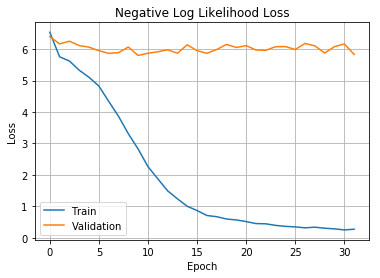

In [32]:
# Plotting Losses
file_name = results_dir+'Losses'+files_suffix+'.png'
plotter = Plotter(train_losses,"Train", val_losses, "Validation")
plotter.plot(file_name)

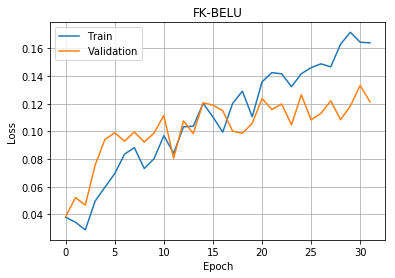

In [33]:
# Plotting FK_Belu
file_name = results_dir+'FK_Belu'+files_suffix+'.png'
plotter = Plotter(fk_belu_train,"Train", fk_belu_val, "Validation", "FK-BELU")
plotter.plot(file_name)